This will plot and compare the resulting data. To run this, make sure that you have already generated all data you want to be compared. For instructions on how to run the generation, see README-new.md

In [238]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
from pylatex import Document, Package, Section, NoEscape

from cloudmesh.common.Shell import Shell
from cloudmesh.common.parameter import Parameter
from cloudmesh.common.dotdict import dotdict
from cloudmesh.common.util import writefile

from cloudmesh.common.util import banner
from analysis import get_data, read_log, generate_df
pd.options.mode.chained_assignment = None 


In [239]:
sizes = [100,1000,5000,10000,50000,100000,500000,1000000,2000000,4000000,5000000,6000000,8000000,10000000]

In [240]:
def average_df(df):
    _df = df.groupby(['p','c','size','repeat','sort','user','node'], sort=True, as_index=False).agg({'time':'mean'})
    _df.reset_index()
    return _df

In [241]:
df = generate_df()
print(df.to_string())

      p     c      size  repeat    sort  user  node     time     t
0     1     3   8000000      10      mp  alex  v100    3.183   NaN
1     1     3   8000000      10      mp  alex  v100    2.998   NaN
2     1     3   8000000      10      mp  alex  v100    3.050   NaN
3     1     3   8000000      10      mp  alex  v100    3.114   NaN
4     1     3   8000000      10      mp  alex  v100    2.992   NaN
5     1     3   8000000      10      mp  alex  v100    3.064   NaN
6     1     3   8000000      10      mp  alex  v100    3.123   NaN
7     1     3   8000000      10      mp  alex  v100    3.292   NaN
8     1     3   8000000      10      mp  alex  v100    2.967   NaN
9     1     3   8000000      10      mp  alex  v100    3.087   NaN
10    1     1      1000      10  sorted  alex  v100    0.000   NaN
11    1     1      1000      10  sorted  alex  v100    0.000   NaN
12    1     1      1000      10  sorted  alex  v100    0.000   NaN
13    1     1      1000      10  sorted  alex  v100    0.000  

In [242]:
df = generate_df()
df.loc[df['sort'] == 'seq', 'c'] = 1
df = average_df(df)
print(df.to_string())

     p     c      size  repeat    sort  user  node      time
0    1     1       100      10      mp  alex  v100    0.0147
1    1     1       100      10     seq  alex  v100    0.0006
2    1     1       100      10  sorted  alex  v100    0.0000
3    1     1      1000      10      mp  alex  v100    0.0123
4    1     1      1000      10     seq  alex  v100    0.0055
5    1     1      1000      10  sorted  alex  v100    0.0000
6    1     1      5000      10      mp  alex  v100    0.0169
7    1     1      5000      10     seq  alex  v100    0.0269
8    1     1      5000      10  sorted  alex  v100    0.0010
9    1     1     10000      10      mp  alex  v100    0.0218
10   1     1     10000      10     seq  alex  v100    0.0563
11   1     1     10000      10  sorted  alex  v100    0.0021
12   1     1     50000      10      mp  alex  v100    0.0515
13   1     1     50000      10     seq  alex  v100    0.2859
14   1     1     50000      10  sorted  alex  v100    0.0101
15   1     1    100000  

In [243]:
def average_increase(df, sort):
    _df = df[df['sort'] == sort]
    _df = _df.groupby(['size'], sort=True, as_index=False).agg({'time':'mean'})
    # print(_df)
    avg = _df[_df['size'] == 10000000].iat[0, 1] - _df[_df['size'] == 1000000].iat[0, 1]
    avg = avg / 9.0
    return avg
    

average_increase(df, "seq")

8.754044444444444

In [244]:
def get_values(df, cores, sizes, sorts, users, nodes):
    _df = df[df['c'].isin(cores) & df['size'].isin(sizes) & df['sort'].isin(sorts) & df['user'].isin(users) & df['node'].isin(nodes)]
    return _df

In [245]:
df = get_values(df, list(range(1,30)), sizes, ["mp","sorted", "seq"], ["alex"], ["v100"])

In [246]:
print(df.to_string())

     p   c      size  repeat    sort  user  node     time
0    1   1       100      10      mp  alex  v100   0.0147
1    1   1       100      10     seq  alex  v100   0.0006
2    1   1       100      10  sorted  alex  v100   0.0000
3    1   1      1000      10      mp  alex  v100   0.0123
4    1   1      1000      10     seq  alex  v100   0.0055
5    1   1      1000      10  sorted  alex  v100   0.0000
6    1   1      5000      10      mp  alex  v100   0.0169
7    1   1      5000      10     seq  alex  v100   0.0269
8    1   1      5000      10  sorted  alex  v100   0.0010
9    1   1     10000      10      mp  alex  v100   0.0218
10   1   1     10000      10     seq  alex  v100   0.0563
11   1   1     10000      10  sorted  alex  v100   0.0021
12   1   1     50000      10      mp  alex  v100   0.0515
13   1   1     50000      10     seq  alex  v100   0.2859
14   1   1     50000      10  sorted  alex  v100   0.0101
15   1   1    100000      10      mp  alex  v100   0.0940
16   1   1    

In [247]:
def calculate_speedup(df):
    frames = []
    gb = df.groupby(['p', 'size','repeat','user','node'])
    for x in gb.groups:
        _df = gb.get_group(x)
        # print(_df.to_string())
        seq_time = _df[(_df['sort'] == 'mp') & (_df['c'] == 1)].iat[0, 7]
        # seq_time = _df[_df['sort'] == 'seq'].iat[0, 7]
        # print(seq_time)
        scale = 1 / seq_time
        # print(scale)
        
        _df['speedup'] = _df['time'].rdiv(seq_time)
        frames.append(_df)
    ans = pd.concat(frames)
    return ans

In [248]:
df = calculate_speedup(df)

In [249]:
def calculate_efficiency(df):
    ans = calculate_speedup(df)
    ans['efficiency'] = ans['speedup'] / ans['c']
    return ans

In [250]:
def plot_benchmark(df, x_axis, y_axis, hue, bound=None, tag=None):
    hues = df[hue].unique()
    hues = [str(hue) for hue in hues]
    # name the image
    hues_name = "-".join(hues)
    name = f"{y_axis}-by-{x_axis}-{hue}-{tag}"
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue)
    if bound != None:
        sns.lineplot(data=df, x=x_axis, y=bound, hue=hue, linestyle="dashed", errorbar=None)
    plt.title(name)
    plt.savefig(f"images/{name}.png")
    plt.savefig(f"images/{name}.pdf")

In [251]:
ans = df.copy()
ans['str_c'] = ans['c'].astype(str)
ans['label'] = ans['sort'] + "-1-" + ans['str_c']
ans = get_values(ans, list(range(1,30)), [1000,5000,10000,50000,100000,500000,1000000,5000000,10000000], ["seq","sorted","mp"], ["alex"], ["v100"])
#ans = ans.groupby(['size','sort'], sort=True, as_index=False).agg({'time':'mean'})
ans = ans[(ans['label'] == "mp-1-24") | (ans['label'] == "sorted-1-1") | (ans['label'] == "seq-1-1")]
ans = ans.pivot(index='size',columns='label', values='time')

ans

label,mp-1-24,seq-1-1,sorted-1-1
size,,,
1000,0.0788,0.0055,0.0000
5000,0.0783,0.0269,0.0010
10000,0.0822,0.0563,0.0021
50000,0.0812,0.2859,0.0101
100000,0.0988,0.5455,0.0206
500000,0.2471,3.1286,0.1037
1000000,0.3931,6.8242,0.2502
5000000,1.5251,39.5551,1.5994
10000000,2.8296,85.6106,3.8602


In [252]:
ans = df.copy()
ans['str_c'] = ans['c'].astype(str)
ans['label'] = ans['sort'] + "-1-" + ans['str_c']
ans = get_values(ans, [1, 4, 8, 12, 16, 20, 24], [10000000], ["seq","sorted","mp"], ["alex"], ["v100"])
#ans = ans.groupby(['size','sort'], sort=True, as_index=False).agg({'time':'mean'})
# ans = ans[(ans['label'] == "mp-1-24") | (ans['label'] == "sorted-1-1") | (ans['label'] == "seq-1-1")]
# ans = ans.pivot(index='size',columns='label', values='time')
ans = ans.drop(columns=["p", "repeat", "user", "str_c", "label", "node"])
ans = ans.sort_values(by=['sort','size','c'])
ans = ans.reset_index(drop=True)
ans

,c,size,sort,time,speedup
0,1,10000000,mp,7.7242,1.000000
1,4,10000000,mp,3.4739,2.223495
2,8,10000000,mp,3.1643,2.441045
3,12,10000000,mp,2.4868,3.106080
4,16,10000000,mp,2.8200,2.739078
5,20,10000000,mp,2.8578,2.702848
6,24,10000000,mp,2.8296,2.729785
7,1,10000000,seq,85.6106,0.090225
8,1,10000000,sorted,3.8602,2.000984


In [253]:
a = ans.to_latex(index=False)
writefile("a.tex", a)

/var/folders/9z/_9vl5v9s7mgc48qt12wb56d40000gr/T/ipykernel_48664/854109206.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  a = ans.to_latex(index=False)


In [254]:
df = calculate_speedup(df)
df = calculate_efficiency(df)

In [255]:
def calculate_strong_speedup(df):
    prop_mp = 0.70 # time proportion of multiprocessing merge sort that can be parallelized
    _df = df.copy()
    _df['strong_speedup'] = 1 / ((1 - prop_mp) + (prop_mp / df['c']))
    return _df

In [259]:
plot_df_ss = df.copy()
plot_df_ss = get_values(plot_df_ss, list(range(1, 30)), [10000000], ['mp'], users=['alex'], nodes=['v100'])
plot_df_ss = calculate_strong_speedup(plot_df_ss)
print(plot_df_ss)

     p   c      size  repeat sort  user  node    time   speedup efficiency  \
39   1   1  10000000      10   mp  alex  v100  7.7242  1.000000        1.0   
55   1   2  10000000      10   mp  alex  v100  4.6241  1.670422   0.835211   
69   1   3  10000000      10   mp  alex  v100  4.0253  1.918913   0.639638   
83   1   4  10000000      10   mp  alex  v100  3.4739  2.223495   0.555874   
97   1   5  10000000      10   mp  alex  v100  3.3801  2.285199    0.45704   
111  1   6  10000000      10   mp  alex  v100  3.1675  2.438579    0.40643   
125  1   7  10000000      10   mp  alex  v100  3.1930  2.419104   0.345586   
139  1   8  10000000      10   mp  alex  v100  3.1643  2.441045   0.305131   
153  1   9  10000000      10   mp  alex  v100  3.1158  2.479042   0.275449   
167  1  10  10000000      10   mp  alex  v100  2.7315  2.827824   0.282782   
181  1  11  10000000      10   mp  alex  v100  2.7707  2.787815   0.253438   
195  1  12  10000000      10   mp  alex  v100  2.4868  3.106080 

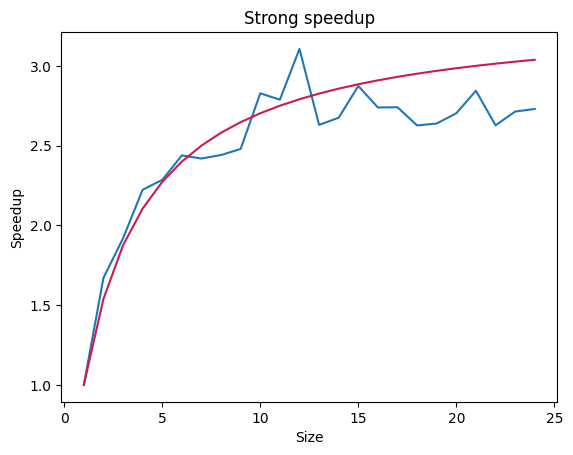

In [272]:
sns.lineplot(data=plot_df_ss, x='c', y='speedup', hue='sort', legend=False)
# ss = pd.Series(plot_df_ss['strong_speedup'])
sns.lineplot(data=plot_df_ss, x='c', y='strong_speedup', hue='sort', palette='rocket', legend=False)
plt.title("Strong speedup")
plt.xlabel("Size")
plt.ylabel("Speedup")
# plt.legend(title='Data', loc='upper left', labels=['speedup', 'strong speedup'], labelcolor=['blue', 'red'])

plt.savefig(f"images/strong_speedup.png")
# plt.savefig(f"images/speedup-by-size-self-mp-1-6-mp-1-12-mp-1-28-mp-1-24.png")
# sns.lineplot(data=seq_c[1], x='size', y='time', hue='label', errorbar=None)

In [197]:
plot_df = df.copy()
plot_df = get_values(df, [6, 12, 18, 24], sizes, ['mp'], users=['alex'], nodes=['v100'])
plot_df['str_c'] = plot_df['c'].astype(str)
plot_df['label'] = plot_df['sort'] + "-1-" + plot_df['str_c']
# plot_df = plot_df[plot_df['size'] == 10000000]
# plot_df = plot_df[plot_df['sort'] == 'mp']
plot_df

,p,c,size,repeat,sort,user,node,time,speedup,str_c,label
98,1,6,100,10,mp,alex,v100,0.0308,0.477273,6,mp-1-6
182,1,12,100,10,mp,alex,v100,0.0491,0.299389,12,mp-1-12
266,1,18,100,10,mp,alex,v100,0.0649,0.226502,18,mp-1-18
350,1,24,100,10,mp,alex,v100,0.0818,0.179707,24,mp-1-24
99,1,6,1000,10,mp,alex,v100,0.0305,0.403279,6,mp-1-6
183,1,12,1000,10,mp,alex,v100,0.0476,0.258403,12,mp-1-12
267,1,18,1000,10,mp,alex,v100,0.0596,0.206376,18,mp-1-18
351,1,24,1000,10,mp,alex,v100,0.0788,0.156091,24,mp-1-24
100,1,6,5000,10,mp,alex,v100,0.0305,0.554098,6,mp-1-6
184,1,12,5000,10,mp,alex,v100,0.0475,0.355789,12,mp-1-12


In [168]:
sorted = df.copy()
mp = df.copy()
seq = df.copy()
mp = mp[mp['sort'] == 'mp']
seq = seq[seq['sort'] == 'seq']
sorted = sorted[sorted['sort'] == 'sorted']

In [114]:
sorted_c = {}
mp_c = {}
seq_c = {}
for c in [1]:
    sorted_c[c] = sorted[sorted['c'] == c]
    sorted_c[c]['label'] = f'sorted-1-{c}'

for c in range(1, 25):
    mp_c[c] = mp[mp['c'] == c]
    mp_c[c]['label'] = f'mp-1-{c}'

for c in [1]:
    seq_c[c] = seq[seq['c'] == c]
    seq_c[c]['label'] = f'seq-1-{c}'

In [115]:
plot_df = pd.DataFrame(sorted_c[1])
plot_df = plot_df.append(pd.DataFrame(mp_c[8]))
plot_df

/var/folders/9z/_9vl5v9s7mgc48qt12wb56d40000gr/T/ipykernel_48664/904772727.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(pd.DataFrame(mp_c[8]))


,p,c,size,repeat,sort,user,node,time,speedup,efficiency,label
1,1,1,100,10,sorted,alex,v100,0.0000,inf,inf,sorted-1-1
3,1,1,1000,10,sorted,alex,v100,0.0000,inf,inf,sorted-1-1
5,1,1,5000,10,sorted,alex,v100,0.0010,26.900000,26.9,sorted-1-1
7,1,1,10000,10,sorted,alex,v100,0.0021,26.809524,26.809524,sorted-1-1
9,1,1,50000,10,sorted,alex,v100,0.0101,28.306931,28.306931,sorted-1-1
11,1,1,100000,10,sorted,alex,v100,0.0206,26.480583,26.480583,sorted-1-1
13,1,1,500000,10,sorted,alex,v100,0.1037,30.169720,30.16972,sorted-1-1
15,1,1,1000000,10,sorted,alex,v100,0.2502,27.274980,27.27498,sorted-1-1
17,1,1,2000000,10,sorted,alex,v100,0.5661,25.549196,25.549196,sorted-1-1
19,1,1,4000000,10,sorted,alex,v100,1.3936,21.996053,21.996053,sorted-1-1


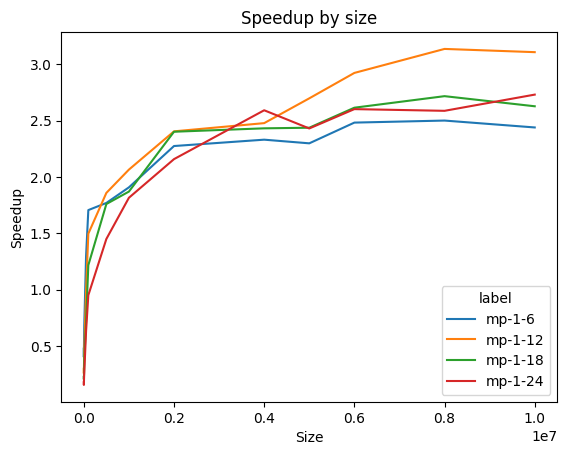

In [198]:
sns.lineplot(data=plot_df, x='size', y='speedup', hue='label')
plt.title("Speedup by size")
plt.xlabel("Size")
plt.ylabel("Speedup")
# plt.savefig(f"images/time-by-c-mp-10e4.png")
plt.savefig(f"images/speedup-by-size-self-mp-1-6-mp-1-12-mp-1-28-mp-1-24.png")
# sns.lineplot(data=seq_c[1], x='size', y='time', hue='label', errorbar=None)

<AxesSubplot: xlabel='size', ylabel='time'>

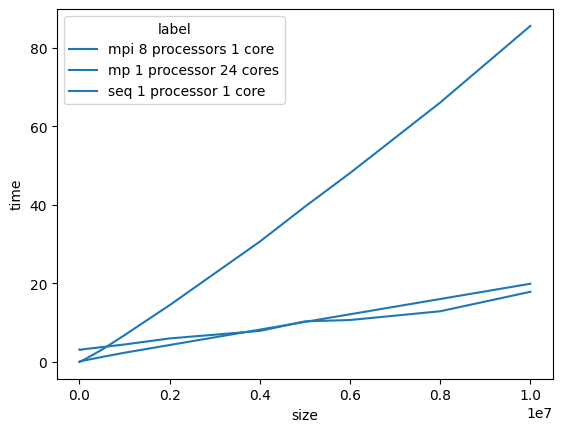

In [146]:
sns.lineplot(data=mpi_p[8], x='size', y='time', hue='label', errorbar=None)
sns.lineplot(data=mp_p[24], x='size', y='time', hue='label', errorbar=None)
sns.lineplot(data=seq_p[1], x='size', y='time', hue='label', errorbar=None)

In [92]:
def generate_table(df, processes, sizes, sorts, users, nodes, columns, label=None, tag=None):
    columns = [str(c) for c in columns]
    name = "-".join(columns)
    ans = get_values(df, processes, sizes, sorts, users, nodes)
    ans = ans[columns]
    if 'time' in columns:
        columns.remove('time')
    ans = ans.groupby(columns, sort=True, as_index=False).agg({'time':'mean'})
    # ans = ans.transpose()
    # ans = ans.pivot(index='size', columns='sort')
    # ans.columns = ans.columns.droplevel(0)
    if tag is not None:
        name = f"{name}-{tag}"

    geometry_options = {"tmargin": "1cm", "lmargin": "10cm"}
    doc = Document(geometry_options=geometry_options)
    doc.packages.append(Package('booktabs'))

    with doc.create(Section(f"{label}")) as target:
        target.append(NoEscape(ans.style.hide().to_latex(hrules=True)))
    
    doc.generate_pdf(f"images/{name}", clean_tex=False)
    # ans.style.to_latex(NoEscape(f'images/{name}.tex'))
    # lat_new = df.style.hide(axis="index").to_latex(hrules=True)



In [99]:
ans = generate_table(df, list(range(1,30)), [10000], ["mp"], ["alex"], ["v100"], ['p', 'time', 'sort'], label="Size=10000", tag="10000")
print(ans)

None


In [40]:
df = calculate_speedup(df)
df = calculate_strong_speedup(df)
df

,p,size,repeat,sort,user,node,t,c,time,speedup,strong_speedup
0,1,100,10,mp,alex,v100,None,None,0.0150,0.040000,1.000000
1,1,100,10,seq,alex,v100,None,None,0.0006,1.000000,1.000000
28,2,100,10,mp,alex,v100,None,None,0.0227,0.026432,1.481481
29,2,100,10,mpi,alex,v100,None,None,2.8829,0.000208,1.538462
56,3,100,10,mp,alex,v100,None,None,0.0255,0.023529,1.764706
...,...,...,...,...,...,...,...,...,...,...,...
289,20,10000000,10,mp,alex,v100,None,None,21.1380,4.050080,2.614379
299,21,10000000,10,mp,alex,v100,None,None,20.7588,4.124063,2.625000
309,22,10000000,10,mp,alex,v100,None,None,20.4045,4.195673,2.634731
319,23,10000000,10,mp,alex,v100,None,None,19.9842,4.283914,2.643678


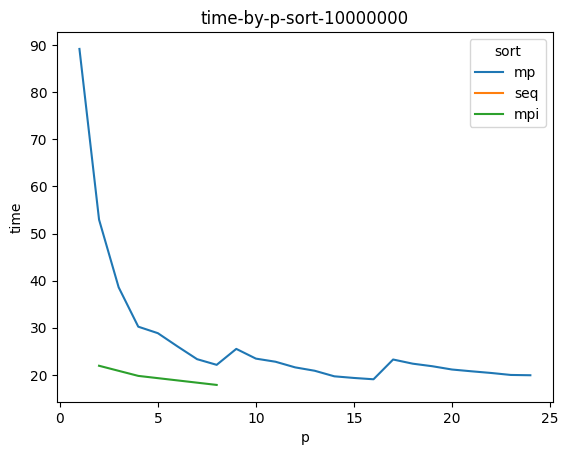

In [58]:
plot_benchmark(df, 'p', 'time', 'sort', tag='10000000')

In [ ]:
def get_values(df, processes, sizes, sorts, users, nodes):
    _df = df[df['p'].isin(processes) & df['size'].isin(sizes) & df['sort'].isin(sorts) & df['user'].isin(users) & df['node'].isin(nodes)]
    return _df

In [ ]:
df = get_values(df, list(range(1,30)), [10000000], ["mp","mpi","seq"], ["alex"], ["v100"])

In [ ]:
df

In [ ]:
plot_benchmark(df, 'p', 'time', 'sort')

In [ ]:
def calculate_weak_speedup(df):
    prop_mp = 0.30 # time proportion of multiprocessing merge sort that can be parallelized
    prop_mpi = 0.10 # time proportion of MPI merge sort that can be parallelized
    conditions = [
        (df['sort'] == 'seq'),
        (df['sort'] == 'mp'),
        (df['sort'] == 'mpi')
    ]

    values = [1, prop_mp, prop_mpi]

    df['prop'] = np.select(conditions, values)
    df['weak_speedup'] = (1 - df['prop']) + (df['prop'] * df['p'])
    df = df.drop(columns=['prop'])
    return df
